# CheXagent disease classification on [NIH Chest X-ray data](https://www.kaggle.com/datasets/nih-chest-xrays/sample/data)


###### Imports


In [1]:
import io
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image
from rich import print
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

###### Function definitions


In [2]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content)).convert("RGB")


def generate(images, prompt, processor, model, device, dtype, generation_config):
    inputs = processor(images=images[:2], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(
        device=device, dtype=dtype
    )
    output = model.generate(
        **inputs,
        generation_config=generation_config,
        # this silences "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
        pad_token_id=processor.tokenizer.eos_token_id,
    )[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    return response


def plot_img(image, title):
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()


def count_substrings(input_string):
    labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8

    cumulative_count = 0
    for substring in labels:
        cumulative_count += input_string.count(substring)

    return cumulative_count


def is_label_in_response(series):
    if series["finding_labels"] in series["response"]:
        return True
    else:
        return False


def is_true_positive(series):
    if series["label_in_response"] and (
        series["response_num_findings"] == series["response"].transform(count_substrings)
    ):
        return True
    else:
        return False


def true_positives(series):
    label_list = series["finding_labels"].split("|")
    true_positives = [label for label in label_list if label in series["response"]]
    # for label in label_list:
    #     if label in series["response"]:
    #         true_positives.append(label)
    return true_positives


def false_positives(series):
    label_list = series["finding_labels"].split("|")
    conditions = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
    fp_options = [x for x in conditions if x not in label_list]
    false_positives = [fp for fp in fp_options if fp in series["response"]]
    # for option in fp_options:
    #     if option in series["response"]:
    #         false_positives.append(option)
    return false_positives


def true_negatives(series):
    labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
    negatives = [label for label in labels if label not in series["response"]]
    predictions = series["true_positives"] + series["false_positives"]
    true_negatives = [x for x in negatives if x not in predictions]
    return true_negatives


def false_negatives(series):
    labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
    positives = [label for label in labels if label in series["finding_labels"]]
    predictions = series["true_positives"] + series["false_positives"]
    negatives_predicted = [x for x in labels if x not in predictions]
    false_negatives = [x for x in negatives_predicted if x in positives]
    return false_negatives


def disp_df(dataframe):
    display(dataframe.head())
    print(f"nRows: {dataframe.shape[0]:,}\tnColumns: {dataframe.shape[1]}")

## NIH Chest X-ray dataset


###### Load dataset


In [3]:
column_names = ["image_index", "finding_labels", "follow_up_number", "patient_id", "patient_age", "patient_gender", "view_position", "original_image_width", "original_image_height", "original_image_pixel_spacing_x", "original_image_pixel_spacing_y"]  # fmt: skip # nopep8

data = pd.read_csv(
    "./data/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv",
    names=column_names,
    header=0,
    index_col=False,
)
display(data.head())
print(f"Rows: {data.shape[0]:,}\tColumns: {data.shape[1]}")
print(f"Number of patients: {data['patient_id'].nunique():,}")

,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_image_width,original_image_height,original_image_pixel_spacing_x,original_image_pixel_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


Rows: 112,120   Columns: 11

Number of patients: 30,805

###### Visualize data


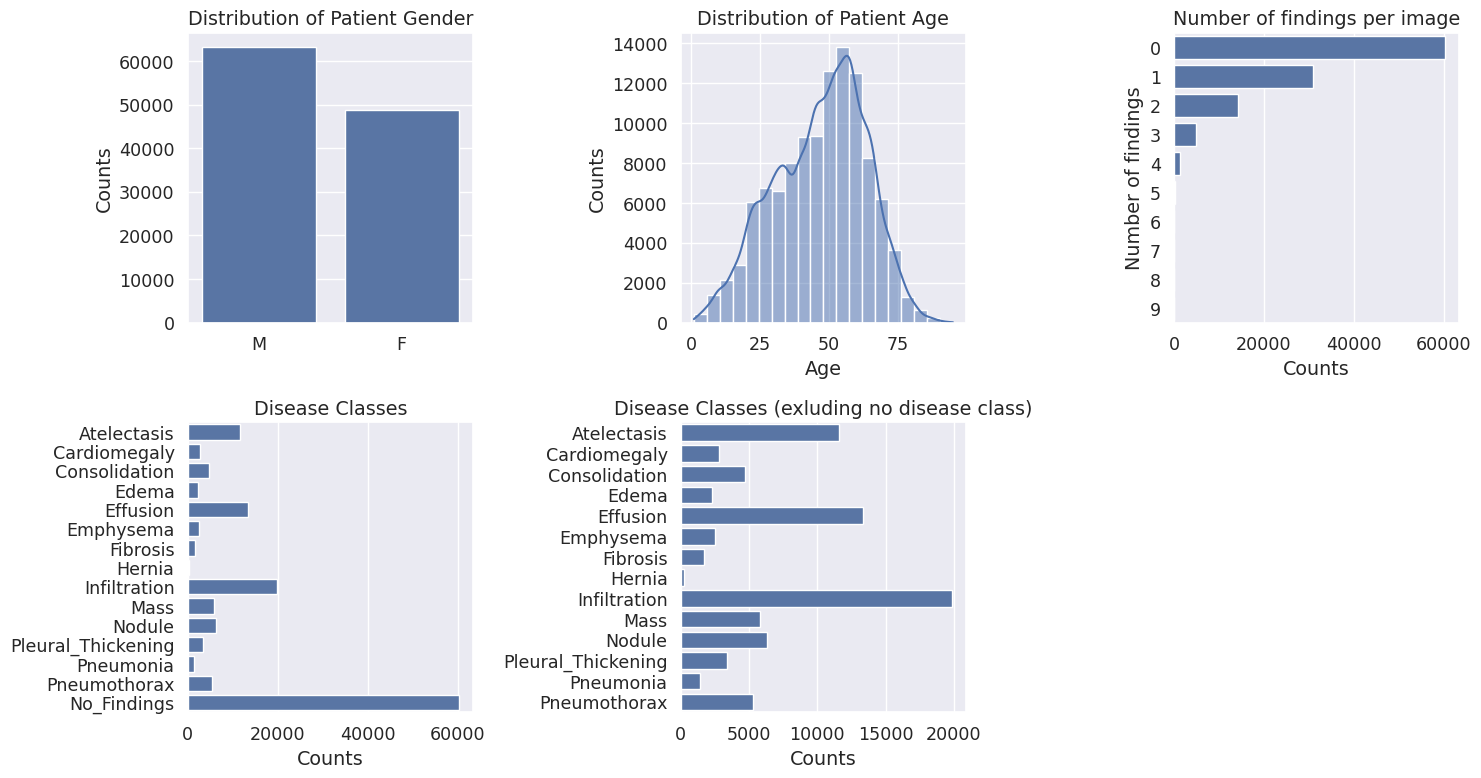

In [4]:
GOLDEN = (1 + 5**0.5) / 2
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.countplot(x=data["patient_gender"])
plt.gca().set(title="Distribution of Patient Gender", xlabel=None, ylabel="Counts")

plt.subplot(2, 3, 2)
sns.histplot(data=data[data["patient_age"] < 130], x="patient_age", bins=20, kde=True)
plt.gca().set(title="Distribution of Patient Age", xlabel="Age", ylabel="Counts")

# Create boolean columns for each pathology type
pathology_list = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]  # fmt: skip # nopep8
for pathology in pathology_list:
    data[pathology] = data["finding_labels"].apply(lambda x: 1 if pathology in x else 0)

data["No_Findings"] = data["finding_labels"].apply(lambda x: 1 if "No Finding" in x else 0)

plt.subplot(2, 3, 3)
sns.barplot(data.iloc[:, 11:-1].sum(axis=1).value_counts(), orient="h")
plt.gca().set(title="Number of findings per image", xlabel="Counts", ylabel="Number of findings")

# Sum of values across selected columns and reset index for Seaborn
sum_data = data.iloc[:, 11:].sum().reset_index()
sum_data.columns = ["Feature", "Total"]

plt.subplot(2, 3, 4)
sns.barplot(x="Total", y="Feature", data=sum_data)
plt.gca().set(title="Disease Classes", xlabel="Counts", ylabel=None)

plt.subplot(2, 3, 5)
sns.barplot(x="Total", y="Feature", data=sum_data.loc[sum_data["Feature"] != "No_Findings", :])
plt.gca().set(title="Disease Classes (exluding no disease class)", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

###### remove calculated columns


In [5]:
data = data[column_names]

## Analyze prompts and responses


###### import results


In [6]:
# filelist = [x.as_posix() for x in Path("output").rglob("disease_classification_QA*.csv")]
filelist = [x.as_posix() for x in Path("output").rglob("CheXagent_results_on_NIH_CXR.csv.gz")]
results = pd.DataFrame()
for f in filelist:
    df_i = pd.read_csv(f, usecols=["image_index", "finding_labels", "prompt_key", "response"], dtype=str)
    results = pd.concat([results, df_i])

results = results.drop_duplicates(ignore_index=True)
results["n_labels"] = results["finding_labels"].transform(count_substrings)
results = results[["image_index", "finding_labels", "n_labels", "prompt_key", "response"]]

disp_df(results)

,image_index,finding_labels,n_labels,prompt_key,response
0,00007109_020.png,Fibrosis|Pneumonia,2,11,Atelectasis
1,00007109_020.png,Fibrosis|Pneumonia,2,12,"Atelectasis, Infiltration"
2,00007109_020.png,Fibrosis|Pneumonia,2,13,"A) 'Atelectasis', B) 'Cardiomegaly', C) 'Conso..."
3,00007109_020.png,Fibrosis|Pneumonia,2,14,"L) 'Pleural_Thickening', M) 'Pneumonia'"
4,00007109_020.png,Fibrosis|Pneumonia,2,15,I) 'Infiltration'


nRows: 1,114,710        nColumns: 5

###### analyze response strings


In [7]:
results["response_num_findings"] = results["response"].transform(count_substrings)
results["response_num_findings_grouped"] = results["response_num_findings"].apply(lambda x: 15 if x >= 15 else x)
results["label_in_response"] = results.apply(is_label_in_response, axis=1)
results["true_positives"] = results.apply(true_positives, axis=1)
results["true_positives_len"] = results["true_positives"].transform(len)
results["false_positives"] = results.apply(false_positives, axis=1)
results["false_positives_len"] = results["false_positives"].transform(len)
results["true_negatives"] = results.apply(true_negatives, axis=1)
results["true_negatives_len"] = results["true_negatives"].transform(len)
results["false_negatives"] = results.apply(false_negatives, axis=1)
results["false_negatives_len"] = results["false_negatives"].transform(len)

results["accuracy"] = (results["true_positives_len"] + results["true_negatives_len"]) / 15
results["recall"] = results["true_positives_len"] / (results["true_positives_len"] + results["false_negatives_len"])
results["precision"] = results["true_positives_len"] / (results["true_positives_len"] + results["false_positives_len"])
results["f1"] = (2 * ((results["precision"] * results["recall"]) / (results["precision"] + results["recall"]))).fillna(
    0.0
)
results["specificity"] = results["true_negatives_len"] / (
    results["true_negatives_len"] + results["false_positives_len"]
)

disp_df(results)

,image_index,finding_labels,n_labels,prompt_key,response,response_num_findings,response_num_findings_grouped,label_in_response,true_positives,true_positives_len,...,false_positives_len,true_negatives,true_negatives_len,false_negatives,false_negatives_len,accuracy,recall,precision,f1,specificity
0,00007109_020.png,Fibrosis|Pneumonia,2,11,Atelectasis,1,1,False,[],0,...,1,"[Cardiomegaly, Consolidation, Edema, Effusion,...",14,"[Fibrosis, Pneumonia]",2,0.933333,0.0,0.000000,0.000000,0.933333
1,00007109_020.png,Fibrosis|Pneumonia,2,12,"Atelectasis, Infiltration",2,2,False,[],0,...,2,"[Cardiomegaly, Consolidation, Edema, Effusion,...",13,"[Fibrosis, Pneumonia]",2,0.866667,0.0,0.000000,0.000000,0.866667
2,00007109_020.png,Fibrosis|Pneumonia,2,13,"A) 'Atelectasis', B) 'Cardiomegaly', C) 'Conso...",11,11,False,"[Fibrosis, Pneumonia]",2,...,9,"[Hernia, Mass, Pneumothorax, No Finding]",4,[],0,0.400000,1.0,0.181818,0.307692,0.307692
3,00007109_020.png,Fibrosis|Pneumonia,2,14,"L) 'Pleural_Thickening', M) 'Pneumonia'",2,2,False,[Pneumonia],1,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",13,[Fibrosis],1,0.933333,0.5,0.500000,0.500000,0.928571
4,00007109_020.png,Fibrosis|Pneumonia,2,15,I) 'Infiltration',1,1,False,[],0,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",14,"[Fibrosis, Pneumonia]",2,0.933333,0.0,0.000000,0.000000,0.933333


nRows: 1,114,710        nColumns: 21

In [8]:
# remove outlier case
# results = results.loc[results["response_num_findings"] != 0, :]

###### make categorical columns


In [8]:
# make "prompt_key" categorical
prompt_file_list = Path("data").glob("prompts*")
prompts = {}
for prompt_file in prompt_file_list:
    with open(prompt_file.as_posix(), "r") as json_file:
        data = json.load(json_file)
        prompts.update(data)

prompt_key_order = [int(key) for key in prompts.keys()]
prompt_key_order.sort()
prompt_key_order = [str(key) for key in prompt_key_order]

results["prompt_key"] = pd.Categorical(results["prompt_key"], ordered=True, categories=prompt_key_order)

# make "findings_label" categorical
# findings_label_order = ["No Finding", "Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "Mass", "Emphysema", "Fibrosis", "Consolidation", "Cardiomegaly", "Edema", "Pleural_Thickening", "Pneumonia", "Hernia"]  # fmt: skip # nopep8
# results["finding_labels"] = pd.Categorical(results["finding_labels"], ordered=True, categories=findings_label_order)

In [9]:
# make response_num_findings_grouped, and make categorical
response_num_findings_grouped_order = results["response_num_findings_grouped"].drop_duplicates().sort_values().values
results["response_num_findings_grouped"] = pd.Categorical(
    results["response_num_findings_grouped"], ordered=True, categories=response_num_findings_grouped_order
)

display(results.dtypes)

image_index                        object
finding_labels                     object
n_labels                            int64
prompt_key                       category
response                           object
response_num_findings               int64
response_num_findings_grouped    category
label_in_response                    bool
true_positives                     object
true_positives_len                  int64
false_positives                    object
false_positives_len                 int64
true_negatives                     object
true_negatives_len                  int64
false_negatives                    object
false_negatives_len                 int64
accuracy                          float64
recall                            float64
precision                         float64
f1                                float64
specificity                       float64
dtype: object

#### MultiLabelBinarizer


In [10]:
y_true = results["finding_labels"].str.split("|")
y_pred = results["true_positives"] + results["false_positives"]

In [12]:
classes = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
mlb = MultiLabelBinarizer(classes=classes)
ytrue = mlb.fit_transform(y_true)
ypred = mlb.fit_transform(y_pred)

In [18]:
temp = pd.DataFrame()
temp["y_true"] = mlb.inverse_transform(ytrue)
temp["y_pred"] = mlb.inverse_transform(ypred)

temp

,y_true,y_pred
0,"(Fibrosis, Pneumonia)","(Atelectasis,)"
1,"(Fibrosis, Pneumonia)","(Atelectasis, Infiltration)"
2,"(Fibrosis, Pneumonia)","(Atelectasis, Cardiomegaly, Consolidation, Ede..."
3,"(Fibrosis, Pneumonia)","(Pleural_Thickening, Pneumonia)"
4,"(Fibrosis, Pneumonia)","(Infiltration,)"
...,...,...
1114705,"(Cardiomegaly, Effusion, Emphysema)","(Atelectasis, Cardiomegaly, Consolidation, Ede..."
1114706,"(Cardiomegaly, Effusion, Emphysema)","(Atelectasis, Cardiomegaly, Consolidation, Ede..."
1114707,"(Cardiomegaly, Effusion, Emphysema)","(Atelectasis,)"
1114708,"(Cardiomegaly, Effusion, Emphysema)","(Consolidation,)"


In [19]:
temp.explode(["y_true", "y_pred"])

ValueError: columns must have matching element counts

In [231]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ytrue, ypred)
print("Accuracy: ", accuracy)

Accuracy:  0.2680526773779727

In [235]:
from sklearn.metrics import hamming_loss

hammingloss = hamming_loss(ytrue, ypred)
print("Hamming Loss: ", hammingloss)

Hamming Loss:  0.18928618205631959

In [236]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(ytrue, ypred, average="samples")  # 'samples' for instance-wise computation
recall = recall_score(ytrue, ypred, average="samples")
f1 = f1_score(ytrue, ypred, average="samples")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

/home/mark/miniforge3/envs/myenv_pip_first/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision:  0.3340587308113616

Recall:  0.4202601648261282

F1 Score:  0.3341632744254991

In [237]:
from sklearn.metrics import jaccard_score

jaccard = jaccard_score(ytrue, ypred, average="samples")  # 'samples' for individual sample computation
print("Jaccard Score: ", jaccard)

Jaccard Score:  0.31156400865150236

In [241]:
for class_index, class_name in enumerate(mlb.classes_):
    class_precision = precision_score(ytrue[:, class_index], ypred[:, class_index])
    class_recall = recall_score(ytrue[:, class_index], ypred[:, class_index])
    class_f1 = f1_score(ytrue[:, class_index], ypred[:, class_index])
    print(f"{class_name}: Precision={class_precision}, Recall={class_recall}, F1={class_f1}")

Atelectasis: Precision=0.15302574095283503, Recall=0.5254840546697038, F1=0.2370270476373955

Cardiomegaly: Precision=0.06830720968750342, Recall=0.46088661930136177, F1=0.1189805217756804

Consolidation: Precision=0.09476723294053505, Recall=0.3396544832793001, F1=0.14818833559387715

Edema: Precision=0.05900459743948849, Recall=0.5362749066702649, F1=0.10631202575099642

Effusion: Precision=0.29003415590452514, Recall=0.5557552145861249, F1=0.3811539850838238

Emphysema: Precision=0.04300536351463559, Recall=0.23538322961021946, F1=0.07272382277600328

Fibrosis: Precision=0.02853782211735005, Recall=0.24122461351924826, F1=0.051037685026038324

Hernia: Precision=0.0021317700353074413, Recall=0.05750224618149147, F1=0.004111128954552754

Infiltration: Precision=0.2441691016567897, Recall=0.16762949433590543, F1=0.19878621948437145

Mass: Precision=0.050701057975705746, Recall=0.052956563517625496, F1=0.051804271763538565

Nodule: Precision=0.0676205686472627, Recall=0.10050218798947182, F1=0.08084586807991063

Pleural_Thickening: Precision=0.05055297266835728, Recall=0.43859434682964094, F1=0.09065672914462569

Pneumonia: Precision=0.02171207572931604, Recall=0.48359403419425245, F1=0.041558295403391184

Pneumothorax: Precision=0.08378815344667091, Recall=0.165326166814895, F1=0.11121299023911248

No Finding: Precision=0.7553036803966438, Recall=0.5249498848594291, F1=0.6194032038939333

In [264]:
multilabel_confusion_matrix??

Signature:
multilabel_confusion_matrix(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    labels=None,
    samplewise=False,
)
Source:   
@validate_params(
    {
        "y_true": ["array-like", "sparse matrix"],
        "y_pred": ["array-like", "sparse matrix"],
        "sample_weight": ["array-like", None],
        "labels": ["array-like", None],
        "samplewise": ["boolean"],
    },
    prefer_skip_nested_validation=True,
)
def multilabel_confusion_matrix(
    y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False
):
    """Compute a confusion matrix for each class or sample.

    .. versionadded:: 0.21

    Compute class-wise (default) or sample-wise (samplewise=True) multilabel
    confusion matrix to evaluate the accuracy of a classification, and output
    confusion matrices for each class or sample.

    In multilabel confusion matrix :math:`MCM`, the count of true negatives
    is :math:`MCM_{:,0,0}`, false negatives is :math:`MCM_{:,1,0}`,
    true 

In [268]:
classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax',
 'No Finding']

In [271]:
mlb.inverse_transform(ytrue)

[('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneumonia'),
 ('Fibrosis', 'Pneum

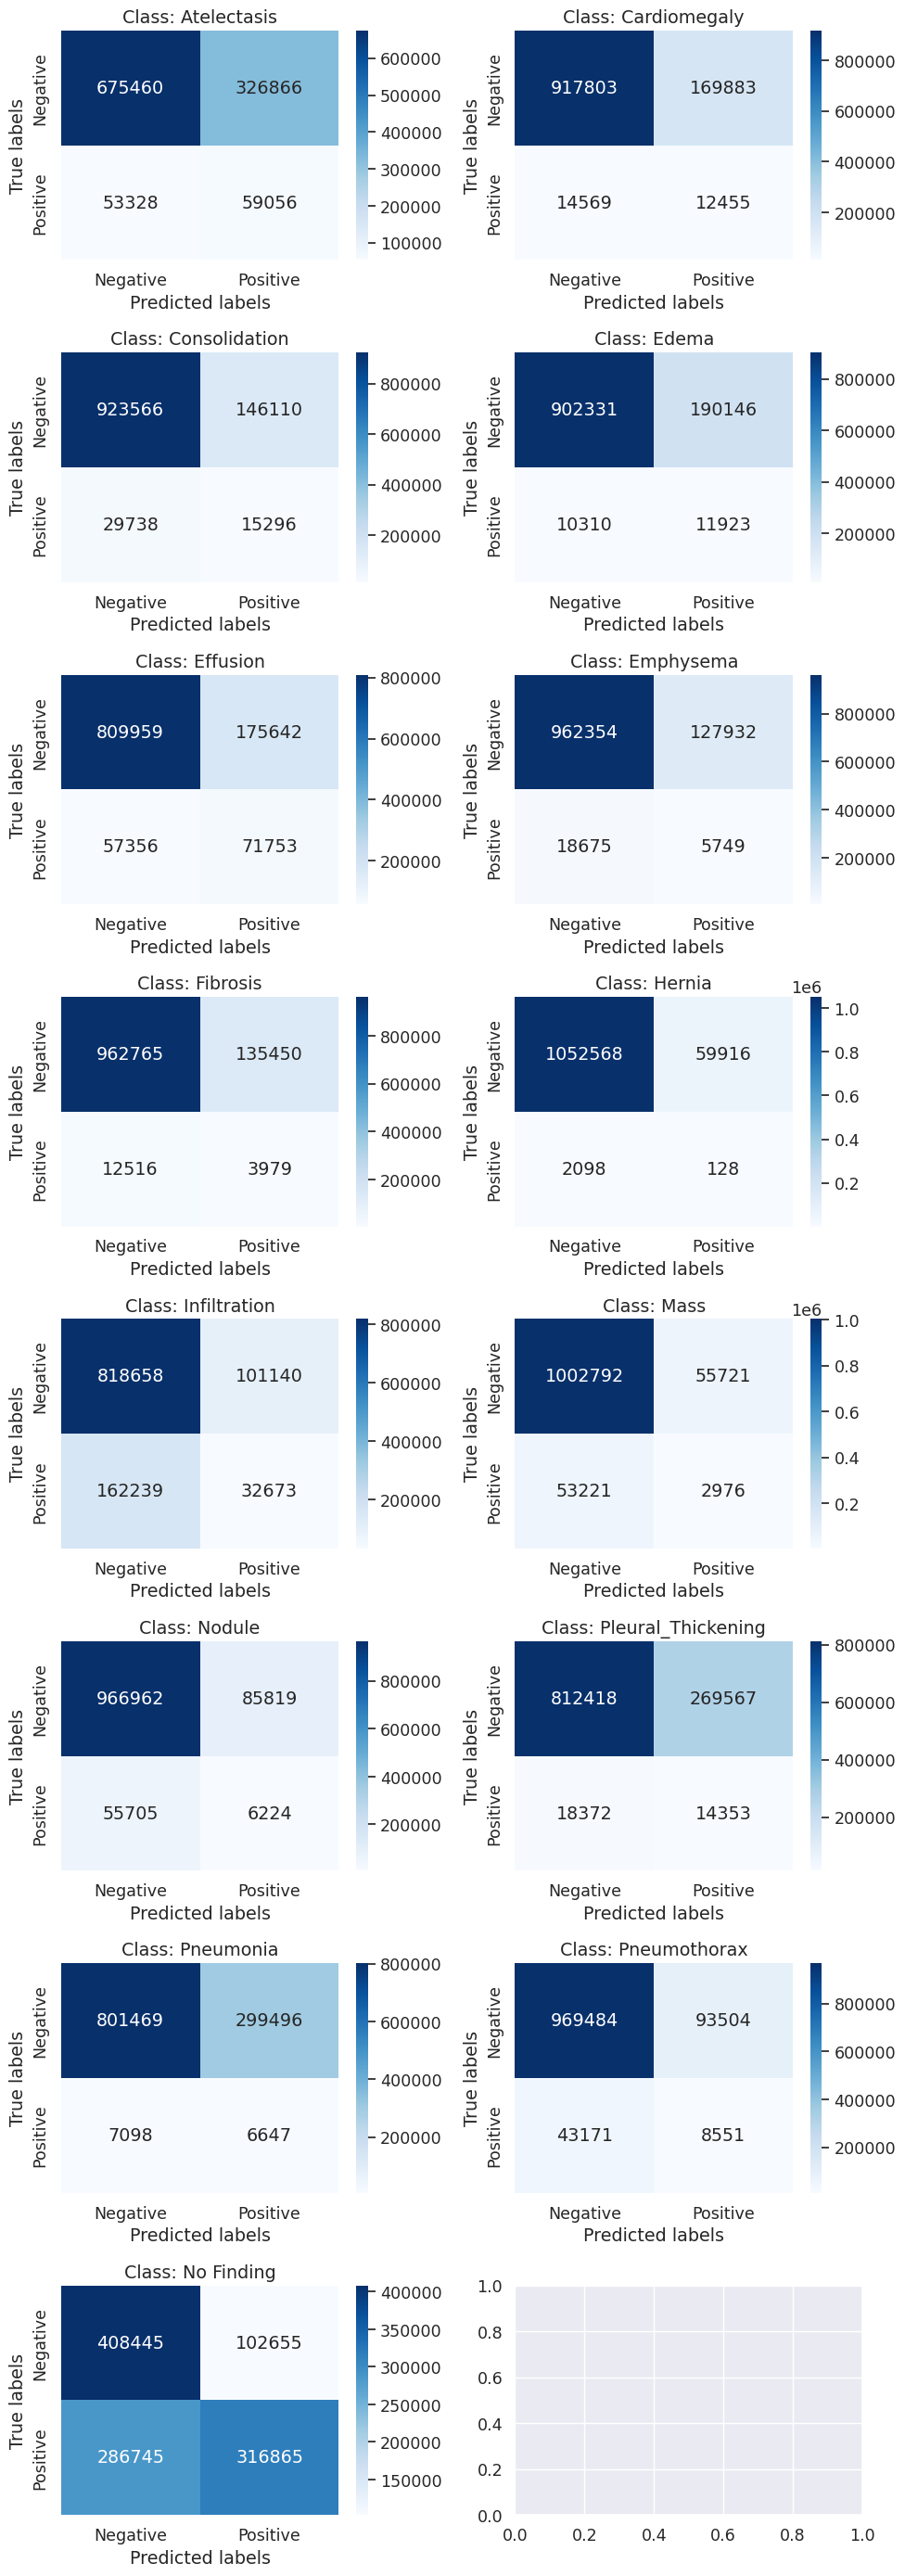

In [251]:
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrices for each class
mcm = multilabel_confusion_matrix(ytrue, ypred)


# Function to plot confusion matrices for each class
def plot_multilabel_confusion_matrix(mcm, classes):
    fig, axes = plt.subplots(
        nrows=int(len(classes) / 2) + len(classes) % 2, ncols=2, figsize=(10, 4 * int(len(classes) / 2))
    )
    for i, (cm, class_name) in enumerate(zip(mcm, classes)):
        ax = axes.flatten()[i]
        sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title(f"Class: {class_name}")
        ax.xaxis.set_ticklabels(["Negative", "Positive"])
        ax.yaxis.set_ticklabels(["Negative", "Positive"])

    plt.tight_layout()
    plt.show()


# Plotting the confusion matrices
plot_multilabel_confusion_matrix(mcm, mlb.classes_)

#### Plots


##### Confusion matrix


In [275]:
conf_matrices = {label: {"TP": 0, "FP": 0, "TN": 0, "FN": 0} for label in classes}


def update_conf_matrix(row, label):
    if label in row["true_positives"]:
        conf_matrices[label]["TP"] += 1
    if label in row["false_positives"]:
        conf_matrices[label]["FP"] += 1
    if label in row["true_negatives"]:
        conf_matrices[label]["TN"] += 1
    if label in row["false_negatives"]:
        conf_matrices[label]["FN"] += 1


for label in classes:
    results.apply(lambda row: update_conf_matrix(row, label), axis=1)


conf_matrices

{'Atelectasis': {'TP': 59056, 'FP': 326866, 'TN': 728788, 'FN': 53328},
 'Cardiomegaly': {'TP': 12455, 'FP': 169883, 'TN': 932372, 'FN': 14569},
 'Consolidation': {'TP': 15296, 'FP': 146110, 'TN': 953304, 'FN': 29738},
 'Edema': {'TP': 11923, 'FP': 190146, 'TN': 912641, 'FN': 10310},
 'Effusion': {'TP': 71753, 'FP': 175642, 'TN': 867315, 'FN': 57356},
 'Emphysema': {'TP': 5749, 'FP': 127932, 'TN': 981029, 'FN': 18675},
 'Fibrosis': {'TP': 3979, 'FP': 135450, 'TN': 975281, 'FN': 12516},
 'Hernia': {'TP': 128, 'FP': 59916, 'TN': 1054666, 'FN': 2098},
 'Infiltration': {'TP': 32673, 'FP': 101140, 'TN': 980897, 'FN': 162239},
 'Mass': {'TP': 2976, 'FP': 55721, 'TN': 1056013, 'FN': 53221},
 'Nodule': {'TP': 6224, 'FP': 85819, 'TN': 1022667, 'FN': 55705},
 'Pleural_Thickening': {'TP': 14353, 'FP': 269567, 'TN': 830790, 'FN': 18372},
 'Pneumonia': {'TP': 6647, 'FP': 299496, 'TN': 808567, 'FN': 7098},
 'Pneumothorax': {'TP': 8551, 'FP': 93504, 'TN': 1012655, 'FN': 43171},
 'No Finding': {'TP': 

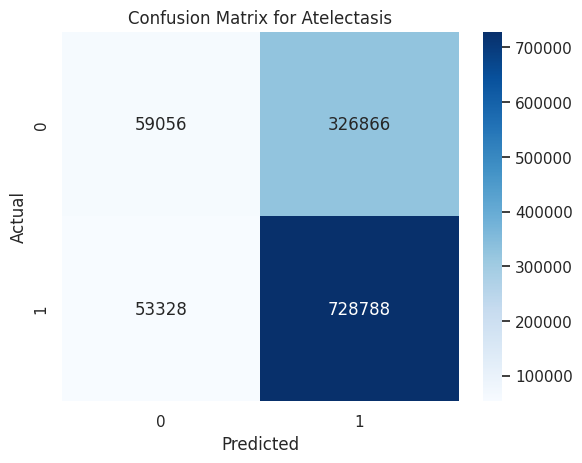

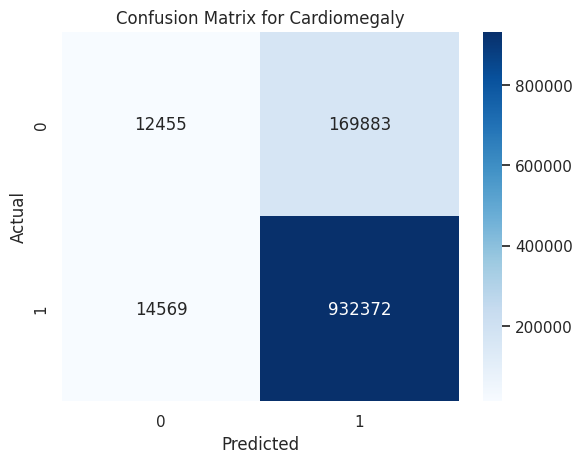

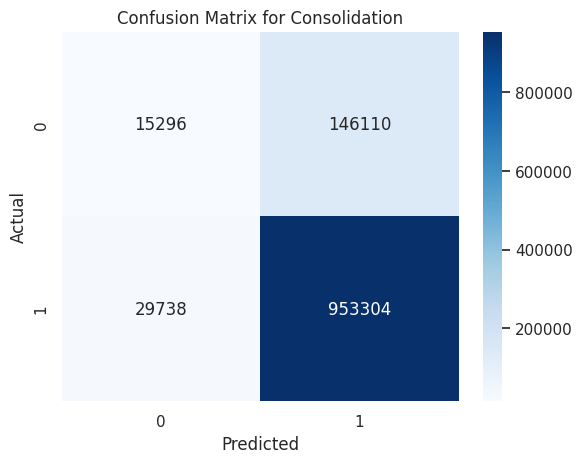

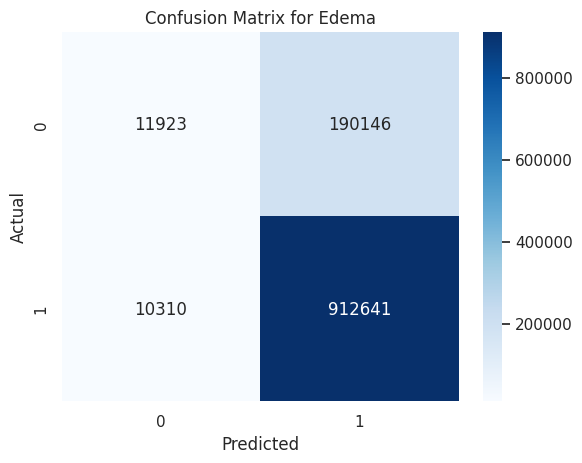

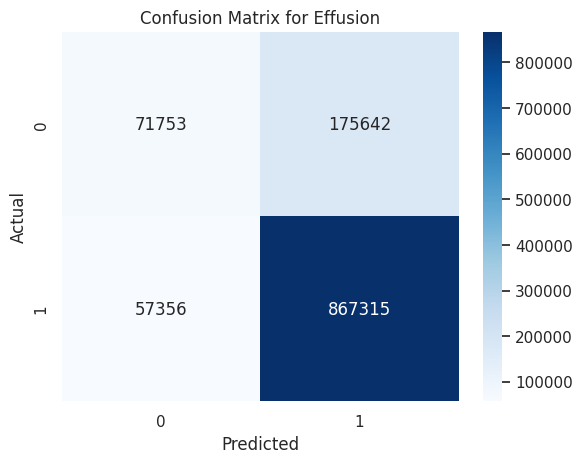

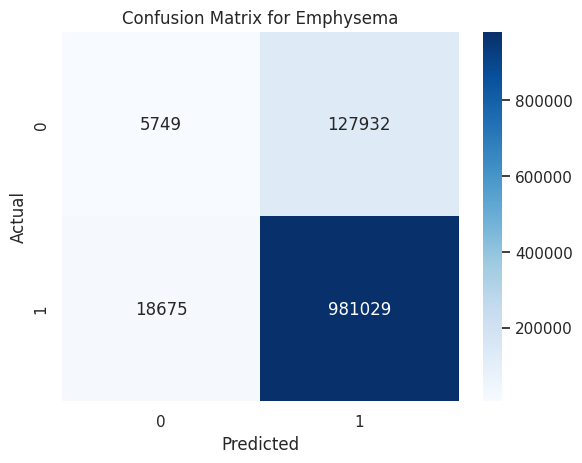

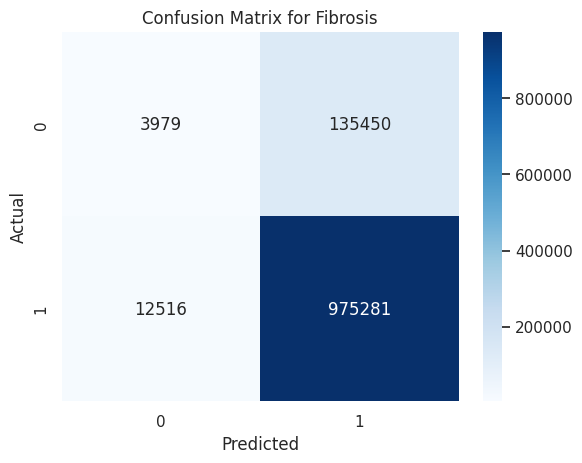

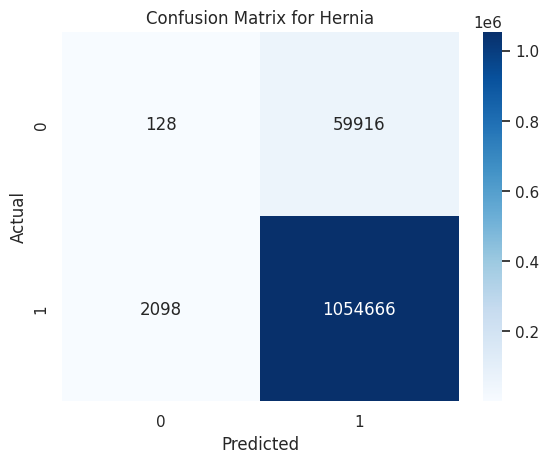

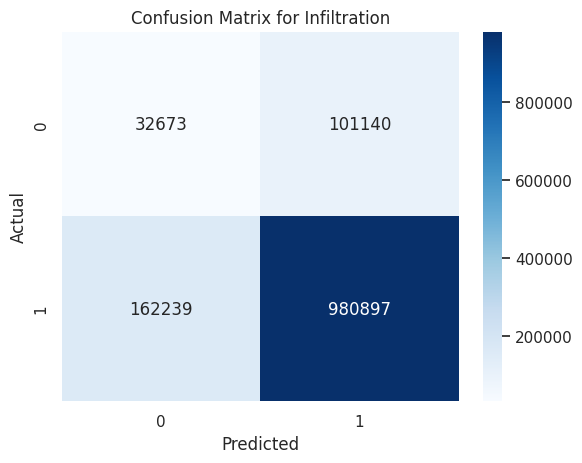

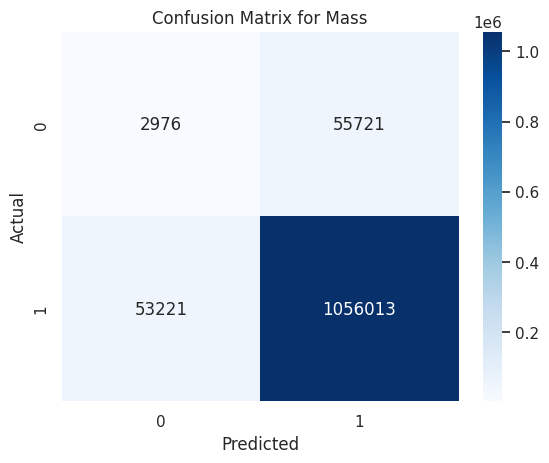

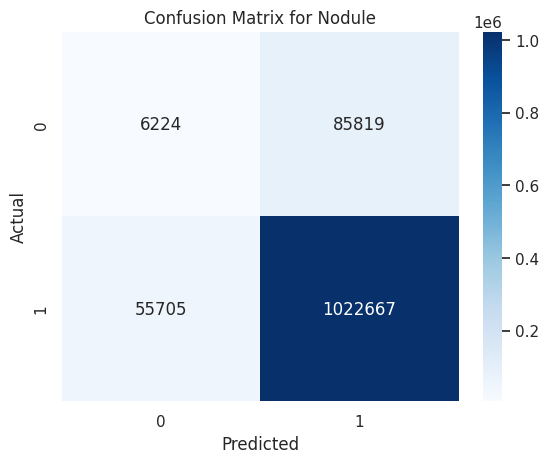

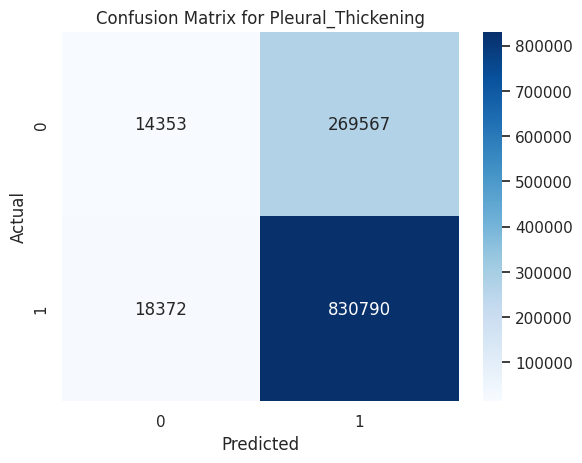

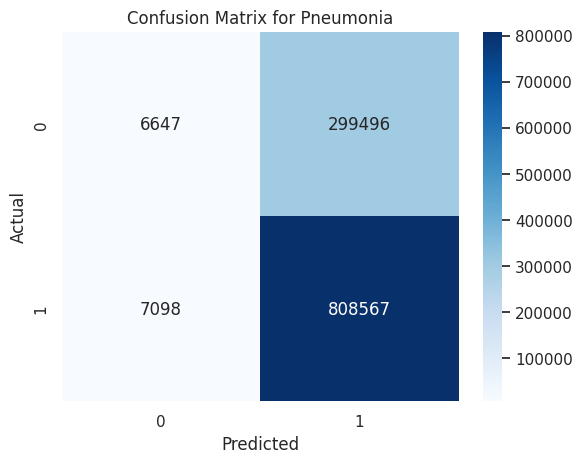

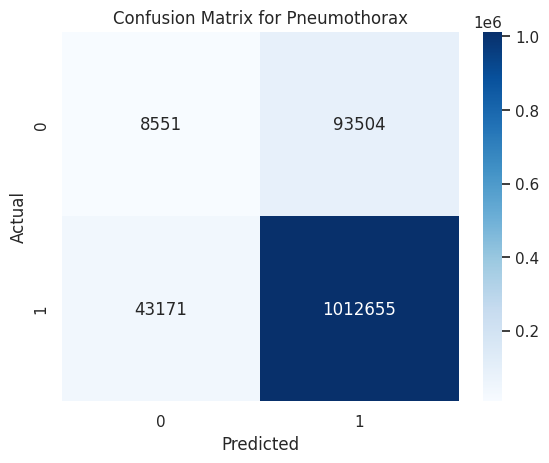

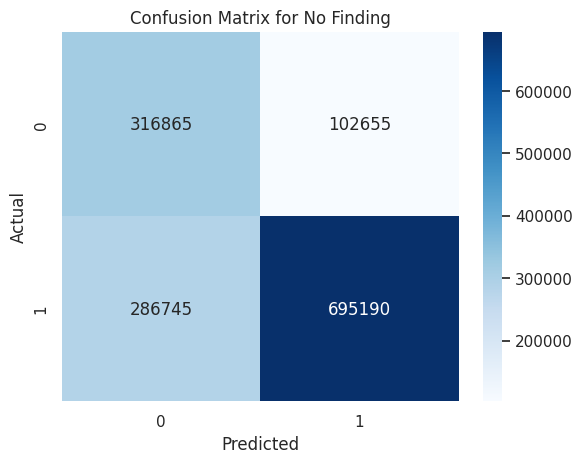

In [276]:
sns.set_theme(style="white")

for label, matrix in conf_matrices.items():
    cm = np.array([[matrix["TP"], matrix["FP"]], [matrix["FN"], matrix["TN"]]])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

##### Histogram on `response_num_findings`


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="prompt_key",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="prompt_key",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Share of no. of findings within generated response by prompt")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="finding_labels",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Share of no. of findings within generated response by GT label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    # palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "right", title="Label in response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    palette="tab20",
)

g.set_axis_labels(x_var="Resp. number of findings")
g.legend.set_title("Finding")
g.tight_layout()
plt.show()

##### Histogram on `prompt_key`


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Is label in generated response?")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Share of generated responses with correct label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="response_num_findings_grouped",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(0.85, 0.5), title="No. labels\nin response")
g.figure.suptitle("Share of number of findings within generated response by prompt")
g.tight_layout()
plt.show()

##### Heatmaps


In [ ]:
sns.set_theme(style="white")

plotdf = (
    results.groupby(["prompt_key", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="prompt_key", index="response_num_findings", values=0)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".0f")
ax.set(title="Number of findings in response by prompt", xlabel="Prompt Key", ylabel="Number of findings in response")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="white", font_scale=1)

plotdf = (
    results.groupby(["finding_labels", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="finding_labels", index="response_num_findings", values=0)
    .transform(lambda x: (x / x.sum()) * 100)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 8, 8))
ax = sns.heatmap(plotdf, annot=True, fmt=".1f")
ax.set(
    title="Number of findings in response by disease\n(values are percentages, columns sum to 100%)",
    xlabel="Disease",
    ylabel="Number of findings in response",
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Multi-finding imags


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.relplot(
    data=results,
    x="response_num_findings_grouped",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()